<h1>A. Data Collection & Exploration

<h2>Import libraries

In [1]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns
%matplotlib inline
import sklearn
import xgboost as xgb
import math
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from mpl_toolkits import mplot3d
from sklearn.preprocessing import LabelEncoder
from pylift import TransformedOutcome
from pylift.generate_data import dgp
from pylift.eval import UpliftEval
from sklearn.cluster import KMeans
from statistics import mean
import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

<h2>Import dataset

In [2]:
df_data = pd.read_csv('turnover.csv', encoding = "ISO-8859-1")
df_data.index.name = "id"
df_model = df_data.copy()

In [3]:
df_data

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
id,,,,,,,,,,,,,,,,
0,7.030801,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,10.611910,0,f,41.0,Banks,HR,rabrecNErab,my head,m,white,bus,8.6,3.4,2.6,4.8,8.3
1125,10.611910,0,f,41.0,Banks,HR,rabrecNErab,my head,m,white,bus,8.6,3.4,2.6,4.8,8.3
1126,118.800821,0,f,34.0,Telecom,Accounting,KA,no,f,white,bus,4.6,5.5,7.2,6.3,3.7


<h2>Define Cols

In [4]:
#choose the single dependent variable (Positive Outcome)
treat = 'coach'

In [5]:
#choose the treatment variable
target = "event"

In [6]:
#choose a column with hiearchy to be label encoded
label_cols=[treat, 'gender']

In [7]:
#choose a column with wide range to be clusterred
cluster_cols = ['stag']

<h2>Check uniques for categorical data

In [8]:
#Checking uniques data in Department column
object_cols = [col for col in df_data.columns if df_data[col].dtype == "object"]
for obj in object_cols:
    print('\n', obj)
    for unique in df_data[obj].unique():
        print("{} {}".format(unique,sum(df_data[obj] == unique)))


 gender
m 276
f 853

 industry
Banks 114
PowerGeneration 38
Retail 289
manufacture 145
Consult 74
State 55
etc 94
Building 41
IT 122
 HoReCa 11
Telecom 36
Pharma 20
Mining 24
transport 38
Agriculture 15
RealEstate 13

 profession
HR 757
Commercial 23
Marketing 31
etc 37
Sales 66
BusinessDevelopment 27
Finanñe 17
Teaching 12
manage 22
IT 74
Law 7
Consult 25
Engineer 15
PR 6
Accounting 10

 traffic
rabrecNErab 211
empjs 248
youjs 318
referal 95
advert 33
KA 67
recNErab 39
friends 118

 coach
no 683
yes 132
my head 314

 head_gender
f 545
m 584

 greywage
white 1002
grey 127

 way
bus 681
car 331
foot 117


In [9]:
df_model

,stag,event,gender,age,industry,profession,traffic,coach,head_gender,greywage,way,extraversion,independ,selfcontrol,anxiety,novator
id,,,,,,,,,,,,,,,,
0,7.030801,1,m,35.0,Banks,HR,rabrecNErab,no,f,white,bus,6.2,4.1,5.7,7.1,8.3
1,22.965092,1,m,33.0,Banks,HR,empjs,no,m,white,bus,6.2,4.1,5.7,7.1,8.3
2,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,6.2,6.2,2.6,4.8,8.3
3,15.934292,1,f,35.0,PowerGeneration,HR,rabrecNErab,no,m,white,bus,5.4,7.6,4.9,2.5,6.7
4,8.410678,1,m,32.0,Retail,Commercial,youjs,yes,f,white,bus,3.0,4.1,8.0,7.1,3.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1124,10.611910,0,f,41.0,Banks,HR,rabrecNErab,my head,m,white,bus,8.6,3.4,2.6,4.8,8.3
1125,10.611910,0,f,41.0,Banks,HR,rabrecNErab,my head,m,white,bus,8.6,3.4,2.6,4.8,8.3
1126,118.800821,0,f,34.0,Telecom,Accounting,KA,no,f,white,bus,4.6,5.5,7.2,6.3,3.7


<h1>B. Data Preprocessing

<h2>Label encoding hierarchy columns

In [10]:
#Label encoding
print("label encoding columns:",label_cols)
label_encoder = LabelEncoder()
for col in label_cols:
    df_model[col] = label_encoder.fit_transform(df_data[col])
    df_model[col] = label_encoder.transform(df_data[col])
print(">>label encoding finished")

label encoding columns: ['coach', 'gender']
>>label encoding finished


<h2>Data cleaning

In [11]:
#remove unused columns
###
#remove unused rows
df_model = df_model.loc[df_model[treat] <=1]
#rename target column to 'Stay'
df_model = df_model.rename(columns={target: "Stay"})
df_data = df_data.rename(columns={target: "Stay"})

In [12]:
desc = pd.DataFrame()
desc['total N'] = [len(df_model)]
desc['total C'] = [sum(df_model[treat]==0)]
desc['total T'] = [sum(df_model[treat]==1)]
desc['total CR'] = [sum(df_model[treat]==0)&sum(df_model['Stay']==1)]
desc['total CN'] = [sum(df_model[treat]==0)&sum(df_model['Stay']==0)]
desc['total TR'] = [sum(df_model[treat]==1)&sum(df_model['Stay']==1)]
desc['total TN'] = [sum(df_model[treat]==1)&sum(df_model['Stay']==0)]
desc

,total N,total C,total T,total CR,total CN,total TR,total TN
0,997,314,683,304,304,160,161


<h2>Cluster & One Hot Encoding

In [13]:
#function to order clusters
# def order_cluster(cluster_field_name, target_field_name,df,ascending):
#     new_cluster_field_name = 'new_' + cluster_field_name
#     df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
#     df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
#     df_new['index'] = df_new.index
#     df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
#     df_final = df_final.drop([cluster_field_name],axis=1)
#     df_final = df_final.rename(columns={"index":cluster_field_name})
#     return df_final

In [14]:
[col for col in df_model.columns if df_model[col].dtype == "float64"]

['stag',
 'age',
 'extraversion',
 'independ',
 'selfcontrol',
 'anxiety',
 'novator']

In [15]:
# #preparing float columns to cluster
# print('Clustering columns:',cluster_cols)
# #creating the clusters
# for col in cluster_cols:
#     col_cluster = col + "_cluster"
#     kmeans = KMeans(n_clusters=5)
#     kmeans.fit(df_model[[col]])
#     df_model[col_cluster] = kmeans.predict(df_model[[col]])
#     #order the clusters
#     df_model = order_cluster(col_cluster, col, df_model, True)
# print('>>Cluster succeeded!')
# #dropping columns that have been clustered
# df_model = df_model.drop(cluster_cols,axis=1)

#one hot encoding the rest columns
dummies = pd.get_dummies(df_model)
print("\nOne Hot Encoding:",dummies.columns.values)
df_model = dummies
print('>>One Hot Encoding succeeded!')


One Hot Encoding: ['stag' 'Stay' 'gender' 'age' 'coach' 'extraversion' 'independ'
 'selfcontrol' 'anxiety' 'novator' 'industry_ HoReCa'
 'industry_Agriculture' 'industry_Banks' 'industry_Building'
 'industry_Consult' 'industry_IT' 'industry_Mining' 'industry_Pharma'
 'industry_PowerGeneration' 'industry_RealEstate' 'industry_Retail'
 'industry_State' 'industry_Telecom' 'industry_etc' 'industry_manufacture'
 'industry_transport' 'profession_Accounting'
 'profession_BusinessDevelopment' 'profession_Commercial'
 'profession_Consult' 'profession_Engineer' 'profession_Finanñe'
 'profession_HR' 'profession_IT' 'profession_Law' 'profession_Marketing'
 'profession_PR' 'profession_Sales' 'profession_Teaching' 'profession_etc'
 'profession_manage' 'traffic_KA' 'traffic_advert' 'traffic_empjs'
 'traffic_friends' 'traffic_rabrecNErab' 'traffic_recNErab'
 'traffic_referal' 'traffic_youjs' 'head_gender_f' 'head_gender_m'
 'greywage_grey' 'greywage_white' 'way_bus' 'way_car' 'way_foot']
>>One Hot En

<h2>Categorizing target class

Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)
>>Categorizing successfull!


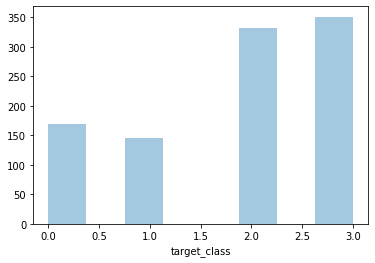

In [16]:
print("Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)")
#to get the CN employees we can simply set the basic value of all data in column target_class equal to 0 
df_model['target_class'] = 0 #CN

#after that we set CR employees with target_class equal to 1 
df_model.loc[(df_model[treat] == 0) & (df_model.Stay > 0),'target_class'] = 1 #CR

#after that we set TN employees with with target_class equal to 2
df_model.loc[(df_model[treat] == 1) & (df_model.Stay == 0),'target_class'] = 2 #TN

#after that we set TR employees with with target_class equal to 3
df_model.loc[(df_model[treat] == 1) & (df_model.Stay > 0),'target_class'] = 3 #TR

print(">>Categorizing successfull!")
sns.distplot(a=df_model.target_class, kde=False)

<h2>Treatment Identification

In [17]:
#measure the correlation of Employee who stay
pd.options.display.max_rows=100
correlation = df_model.corr(method ='pearson') 
pd.DataFrame(round(correlation.Stay.sort_values() * 100,2)).reset_index()

,index,Stay
0,industry_IT,-15.33
1,way_foot,-10.99
2,traffic_friends,-10.71
3,profession_HR,-10.35
4,profession_IT,-7.59
5,traffic_youjs,-7.11
6,anxiety,-6.17
7,head_gender_f,-5.55
8,traffic_advert,-5.28
9,greywage_white,-5.15


<Figure size 216x1440 with 0 Axes>

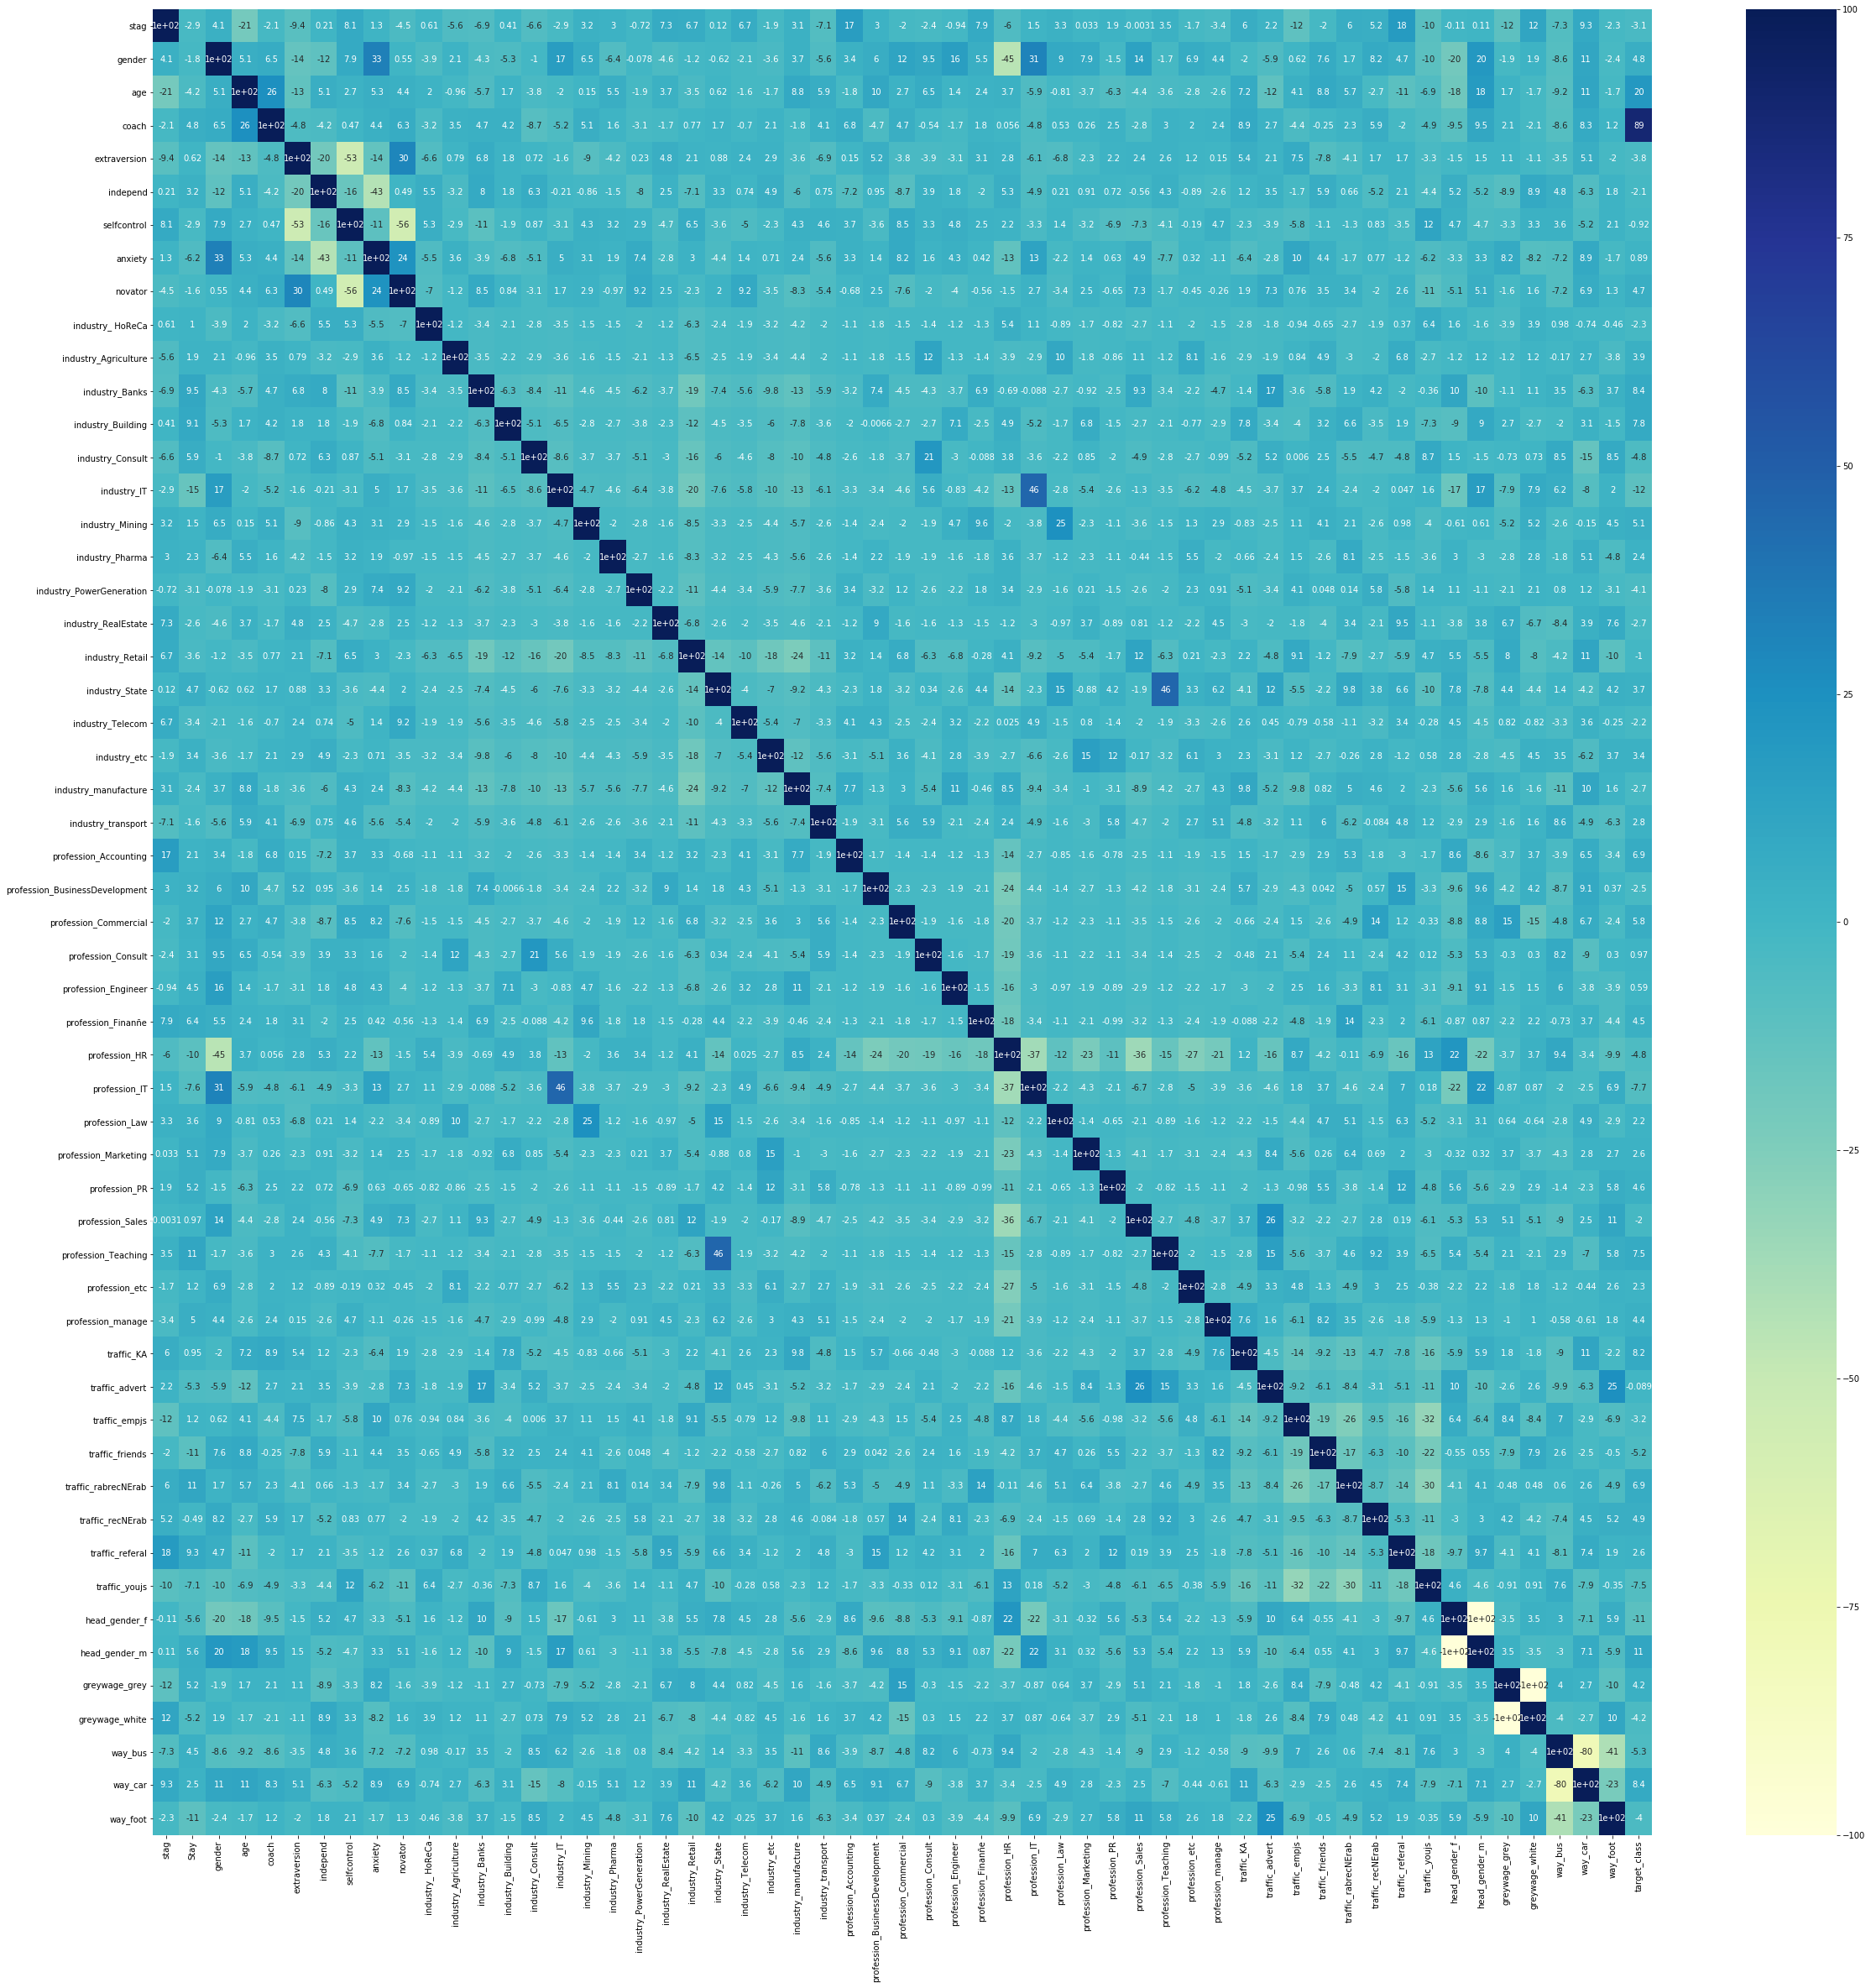

<Figure size 216x1440 with 0 Axes>

In [18]:
#measure the correlation of Employees who stay
treatment_corr_matrix = df_model.corr(method ='pearson')
#plot the data
plt.figure(figsize=(40,40))
corr = pd.DataFrame(treatment_corr_matrix.drop(labels=['Stay', 'target_class'])* 100)
sns.heatmap(corr, annot=True, center=0, cmap="YlGnBu")
plt.figure(figsize=(3,20))

In [19]:
treatment_corr_table = pd.DataFrame(treatment_corr_matrix['Stay'].drop(labels=['Stay', 'target_class']))
treatment_corr_table['target_class'] = pd.DataFrame(treatment_corr_matrix['target_class'].drop(labels=['Stay', 'target_class']))

In [20]:
treat_matrix = treatment_corr_table.copy()
treat_matrix = treat_matrix.abs()*100 < 0
treat_matrix['and'] = treat_matrix.all(axis = 1)
target_labels = [treat, 'target_class','Stay']
drop_both = treat_matrix.index[treat_matrix['and'] == True].tolist()
drop_both.extend(target_labels)
drop_uplift = treat_matrix.index[treat_matrix['target_class'] == True].tolist()
drop_uplift.extend(target_labels)
drop_stay = treat_matrix.index[treat_matrix['Stay'] == True].tolist()
drop_stay.extend(target_labels)

AxesSubplot(0.125,0.125;2.375x1.375)


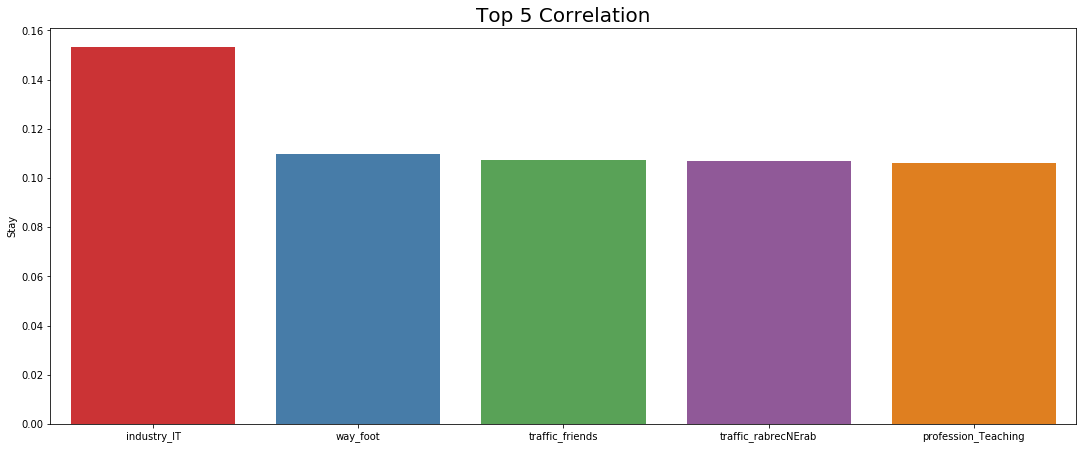

In [21]:
largest_corr = treatment_corr_table.Stay.abs().nlargest(5)
largest = sns.barplot(y=largest_corr,x=largest_corr.index, palette='Set1')
# chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='left')
plt.subplots_adjust(right=2.5)
plt.subplots_adjust(top=1.5)
plt.title('Top 5 Correlation',y=1, fontsize=20)
print(largest)

In [22]:
pd.DataFrame(largest_corr.round(2))

,Stay
industry_IT,0.15
way_foot,0.11
traffic_friends,0.11
traffic_rabrecNErab,0.11
profession_Teaching,0.11


<h2>Create new dataframe for churn and uplift

In [23]:
#create features
X = df_model
#create labels for churn target
y_stay = df_model.Stay
#create labels for treatment
t = df_model[treat]

<h2>Predicting Target (Churn Prediction)

In [24]:
#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y_stay, test_size=0.3, random_state=42, stratify = t)
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model_stay = xgb.XGBClassifier().fit(X_train.drop(drop_stay,axis=1), y_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict_stay = xgb_model_stay.predict(X_test.drop(drop_stay,axis=1))
overall_proba_stay = xgb_model_stay.predict_proba(X_test.drop(drop_stay,axis=1))
# put result in dataframe
df_data_churn = X_test.copy()
df_data_churn['p_stay'] = overall_predict_stay
df_data_churn['stay_score'] = overall_proba_stay[:,0]

In [25]:
# evaluate predictions
accuracy = accuracy_score(y_test, overall_predict_stay)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.00%


In [26]:
confusion = confusion_matrix(y_test, overall_predict_stay)
tn, fp, fn, tp = confusion.ravel()
confusion = pd.DataFrame(confusion, columns = ['True','False'], index = ['Positive','Negative'])
confusion

,True,False
Positive,106,55
Negative,41,98


<h2>Uplift Modeling - 4 Quadrant Generalized

In [27]:
#create labels
y_target_class = df_model.target_class
#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y_target_class, test_size=0.3, random_state=42, stratify=t)

In [28]:
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model_target_class = xgb.XGBClassifier()
xgb_model_target_class = xgb_model_target_class.fit(X_train.drop(drop_uplift,axis=1), y_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict_target_class = xgb_model_target_class.predict(X_test.drop(drop_uplift,axis=1))
overall_proba_target_class=xgb_model_target_class.predict_proba(X_test.drop(drop_uplift,axis=1))

# insert predicted target to uplift dataframe
df_data_uplift = X_test.copy()
df_data_uplift['p_target'] = overall_predict_target_class

# assign probabilities to 4 different columns
df_data_uplift['proba_CN'] = overall_proba_target_class[:,0] 
df_data_uplift['proba_CR'] = overall_proba_target_class[:,1] 
df_data_uplift['proba_TN'] = overall_proba_target_class[:,2] 
df_data_uplift['proba_TR'] = overall_proba_target_class[:,3]

#calculate uplift score for all customers
df_data_uplift['uplift_score'] = df_data_uplift.eval('proba_CN/(proba_CN+proba_CR) + proba_TR/(proba_TN+proba_TR) - proba_TN/(proba_TN+proba_TR) - proba_CR/(proba_CN+proba_CR)')

#assign it back to main dataframe
df_data_uplift['uplift_score'] = df_data_uplift['uplift_score']

In [29]:
# evaluate predictions
accuracy = accuracy_score(y_test, overall_predict_target_class)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 45.00%


In [30]:
multilabel_confusion_matrix(y_test, overall_predict_target_class)

array([[[232,  15],
        [ 35,  18]],

       [[243,  16],
        [ 32,   9]],

       [[128,  64],
        [ 49,  59]],

       [[132,  70],
        [ 49,  49]]], dtype=int64)

<h2>Rank data from Churn prediction

In [31]:
#both treatment and control
print("Ranking data for Churn Prediction with control included")
df_data_churn_all = df_data_churn.copy()
df_data_churn_all = df_data_churn_all.sort_values(by ='stay_score',ascending=False)
df_data_churn_all = df_data_churn_all.reset_index()

#treatment only
df_data_churn = df_data_churn[df_data_uplift.target_class > 1]
print("Ranking data for Churn Prediction with control not included")
df_data_churn = df_data_churn.sort_values(by ='stay_score',ascending=False)
df_data_churn = df_data_churn.reset_index()

Ranking data for Churn Prediction with control included
Ranking data for Churn Prediction with control not included


<h2>Rank data from Uplift prediction

In [32]:
#both treatment and control
print("Ranking data for Churn Uplift with control included")
df_data_uplift_all = df_data_uplift.copy()
df_data_uplift_all = df_data_uplift_all.sort_values(by ='uplift_score',ascending=False)
df_data_uplift_all = df_data_uplift_all.reset_index()

#choose treatment only
df_data_uplift = df_data_uplift[df_data_uplift.target_class > 1]
print("Ranking data for Churn Uplift with control not included")
df_data_uplift = df_data_uplift.sort_values(by ='uplift_score',ascending=False)
df_data_uplift = df_data_uplift.reset_index()

Ranking data for Churn Uplift with control included
Ranking data for Churn Uplift with control not included


In [33]:
sns.set_style("whitegrid")

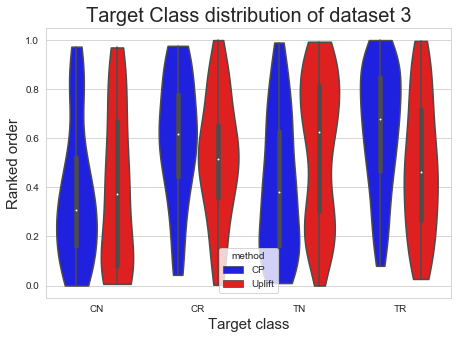

In [34]:
#churn prediction method
churn_target_class = df_data_churn_all.copy()
churn_target_class = churn_target_class.reset_index()
churn_target_class.target_class.replace([0, 1, 2, 3], ['CN', 'CR', 'TN', 'TR'], inplace = True)
churn_target_class['method'] = 'CP'
#uplift method
uplift_target_class = df_data_uplift_all.copy()
uplift_target_class = uplift_target_class.reset_index()
uplift_target_class.target_class.replace([0, 1, 2, 3], ['CN', 'CR', 'TN', 'TR'], inplace = True)
uplift_target_class['method'] = 'Uplift'
#combine both method
all_method_target_class = pd.concat([churn_target_class, uplift_target_class])
max_index = max(all_method_target_class['index'])
all_method_target_class['index'] = all_method_target_class['index']/max_index
plt.figure(figsize=(15,10))
sns.violinplot(data=all_method_target_class, x='target_class', y='index', hue='method', 
               yticklabels=np.arange(0.1,1.1,0.1), cut=0, palette=['blue','red'],
              order=['CN', 'CR', 'TN', 'TR'])
plt.title('Target Class distribution of dataset 3',fontsize=20)
plt.ylabel('Ranked order',fontsize=15)
plt.xlabel('Target class',fontsize=15)
plt.subplots_adjust(right=0.5)
plt.subplots_adjust(top=0.5)

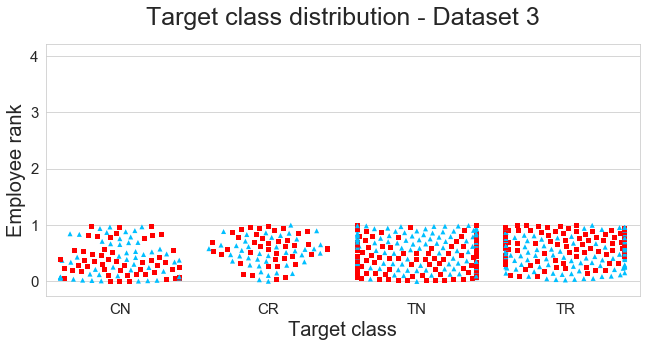

In [35]:
# dummy plots, just to get the Path objects
fig, ax = plt.subplots(1,1)
a = ax.scatter([1,2],[3,4], marker='s')
b = ax.scatter([1,2],[3,4], marker='^')
square_mk, = a.get_paths()
triangle_up_mk, = b.get_paths()
a.remove()
b.remove()


ax = sns.swarmplot(data=all_method_target_class, x='target_class', y='index', 
              hue='method', palette=['red','deepskyblue'], 
                   order=['CN', 'CR', 'TN', 'TR'], size=5, edgecolor = 'black',
                   )
plt.title('Target class distribution - Dataset 3',fontsize=25, y=1.05)
plt.ylabel('Employee rank',fontsize=20)
plt.xlabel('Target class',fontsize=20)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1)

# plt.setp(ax.get_legend().get_texts(), fontsize='15')
ax.tick_params(labelsize=15)

collections = ax.collections
unique_colors = np.unique(collections[0].get_facecolors(), axis=0)
markers = [triangle_up_mk, square_mk]  # this array must be at least as large as the number of unique colors
for collection in collections:
    paths = []
    for current_color in collection.get_facecolors():
        for possible_marker,possible_color in zip(markers, unique_colors):
            if np.array_equal(current_color,possible_color):
                paths.append(possible_marker)
                break
    collection.set_paths(paths)
#update legend
ax.legend_.remove()
# ax.legend(collections[-2:],pd.unique(all_method_target_class.method))  

In [36]:
#store dataset to be used globally
dataset_3 = all_method_target_class
%store dataset_3

Stored 'dataset_3' (DataFrame)


In [37]:
#measure the train data
train_description = pd.Series()
train_description['train_size'] = [len(X_train)]
train_description['train_treatment_response_rate'] = [(round(sum(X_train['target_class'] == 3) /sum(X_train[treat]),4))]
train_description['train_control_response_rate'] = [(round(sum(X_train['target_class'] == 1) /sum(X_train[treat]==0),4))]
#measure the test data
test_description = pd.Series()
test_description['test_size'] = [len(X_test)]
test_description['test_treatment_response_rate'] = [round(sum(X_test['target_class'] == 3) /sum(X_test[treat]),4)]
test_description['test_control_response_rate'] = [round(sum(X_test['target_class'] == 1) /sum(X_test[treat]==0),4)]
#print the result
print(train_description)
print(test_description)

train_size                          [697]
train_treatment_response_rate    [0.5304]
train_control_response_rate      [0.4727]
dtype: object
test_size                          [300]
test_treatment_response_rate    [0.4757]
test_control_response_rate      [0.4362]
dtype: object


C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


<h2> Treatment Only

In [38]:
#define basic variable c=cost, j=decile_count
c=0
j=round(len(df_data_churn)/10)

#prepare 3 dataframe for CPMP
CPMP1 = pd.DataFrame({"n":[], 
                      "retained":[], 
                      "non_retained":[], 
                      "false":[], 
                      "mp":[]})
CUMP1 = CPMP1.copy()

#1
b1=82000
i1=16666
p1_1=(b1-i1-c)
p2_1=(-c)
p3_1=(-i1-c)

CP_list1, CU_list1 = [], []

for i in range(10):
    m=(i+1)*j
    
         
    #Variables for churn Prediction 
    #retained within the segment
    r = sum(df_data_churn.target_class[0:m]==3)
    #not retained within the segment
    nr =  sum(df_data_churn.target_class[0:m]==2)
    #False retained within the segment
    fr = sum(df_data_churn.target_class[0:m]==1)
        
    #Variables for Uplift Modelling
    u_r=sum(df_data_uplift.target_class[0:m]==3)
    u_nr=sum(df_data_uplift.target_class[0:m]==2)
    u_fr=sum(df_data_uplift.target_class[0:m]==1)
    
    
    #Churn Prediction mp 
    #r as r, nr as nr, fr r as fr
    r_profit1=(r*p1_1)
    nr_profit1=(nr*p2_1)
    fr_profit1=(fr*p3_1)
    #churn Maximum Profit
    mp1=(r_profit1 + nr_profit1 + fr_profit1)/m
    
    u_r_profit1=(u_r*p1_1)
    u_nr_profit1=(u_nr*p2_1)
    u_fr_profit1=(u_fr*p3_1)
    #Churn Uplift Maximum Profit
    u_mp1=(u_r_profit1 + u_nr_profit1 + u_fr_profit1)/m
    
    
    CP_list1.append(pd.Series([((i+1)/10), r, nr, fr, mp1], index=CPMP1.columns)) 
    CU_list1.append(pd.Series([((i+1)/10), u_r, u_nr, u_fr, u_mp1], index=CUMP1.columns))
    

CPMP1 = CPMP1.append(CP_list1 , ignore_index=True)

CUMP1 = CUMP1.append(CU_list1 , ignore_index=True)

# add q0 into dataframe
q0 = pd.DataFrame({'n':0, 'mp':0}, index =[0])
CPMP1 = pd.concat([q0, CPMP1]).reset_index(drop = True)

CUMP1 = pd.concat([q0, CUMP1]).reset_index(drop = True)

In [39]:
#create new column method = churn_prediction
CPMP1['method'] = 'MPC'

#create new column method = uplift_modelling Prediction
CUMP1['method'] = 'MPU'
#Combine both Churn Prediction and uplift modelling result
result_mp1 = pd.concat([CUMP1, CPMP1])
result_mp1 = result_mp1.sort_values(by='n')
result_mp1

,n,mp,retained,non_retained,false,method
0,0.0,0.000000,NaN,NaN,NaN,MPU
0,0.0,0.000000,NaN,NaN,NaN,MPC
1,0.1,37333.714286,12.0,9.0,0.0,MPU
1,0.1,9333.428571,3.0,18.0,0.0,MPC
2,0.2,29555.857143,19.0,23.0,0.0,MPU
2,0.2,12444.571429,8.0,34.0,0.0,MPC
3,0.3,33185.523810,32.0,31.0,0.0,MPU
3,0.3,16592.761905,16.0,47.0,0.0,MPC
4,0.4,34222.571429,44.0,40.0,0.0,MPU
4,0.4,17111.285714,22.0,62.0,0.0,MPC


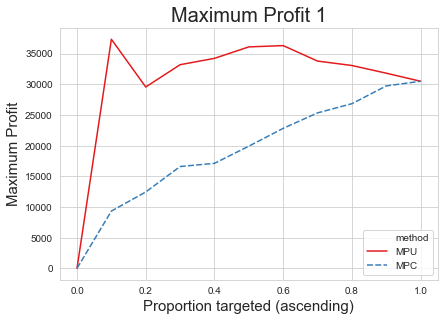

In [40]:
sns.lineplot(x='n', y='mp', hue='method', data=result_mp1, style="method", palette='Set1')
sns.set_style("whitegrid")
plt.title('Maximum Profit 1',fontsize=20)
plt.xlabel('Proportion targeted (ascending)',fontsize=15)
plt.ylabel('Maximum Profit',fontsize=15)
plt.subplots_adjust(right=1)
plt.subplots_adjust(top=1)

In [41]:
#measure the train data
train_description = pd.Series()
train_description['train_size'] = [len(X_train)]
train_description['train_treatment_response_rate'] = [(round(sum(X_train['target_class'] == 3) /sum(X_train[treat]),4))]
train_description['train_control_response_rate'] = [(round(sum(X_train['target_class'] == 1) /sum(X_train[treat]==0),4))]
#measure the test data
test_description = pd.Series()
test_description['test_size'] = [len(X_test)]
test_description['test_treatment_response_rate'] = [round(sum(X_test['target_class'] == 3) /sum(X_test[treat]),4)]
test_description['test_control_response_rate'] = [round(sum(X_test['target_class'] == 1) /sum(X_test[treat]==0),4)]
#print the result
print(train_description)
print(test_description)

train_size                          [697]
train_treatment_response_rate    [0.5304]
train_control_response_rate      [0.4727]
dtype: object
test_size                          [300]
test_treatment_response_rate    [0.4757]
test_control_response_rate      [0.4362]
dtype: object


C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


<h1> EMP

In [42]:
CN, TN, C, T = sum((df_model[treat] == 0)&(df_model['Stay'] == 0)), sum((df_model[treat] == 1)&(df_model['Stay'] == 0)), sum(df_model[treat] == 0), sum(df_model[treat] == 1)
mu_CN = CN/C
mu_CR = 1 - mu_CN
mu_TN = TN/T
mu_TR = 1 - mu_TN

In [43]:
# CN, TN, C, T = sum((df_data_uplift_all[treat] == 0)&(df_data_uplift_all['Stay'] == 0)), sum((df_data_uplift_all[treat] == 1)&(df_data_uplift_all['Stay'] == 0)), sum(df_data_uplift_all[treat] == 0), sum(df_data_uplift_all[treat] == 1)
# mu_CN = CN/C
# mu_CR = 1 - mu_CN
# mu_TN = TN/T
# mu_TR = 1 - mu_TN

In [44]:
#define basic variable c=cost, j=decile_count
k=10
#set decile step/10 or /100
j=round(len(df_data_churn_all)/10)
#prepare 3 dataframe for CPMP
EMP_C = pd.DataFrame({"n":[], 
                      "emp":[]})
EMP_U = EMP_C.copy()
b=100
i_cost=0
d=5
A=0

C_list, U_list = [], []

for i in range(k):
    m=(i+1)*j
    m_max = j*k
    
    #alpha:
    CN_c = sum(df_data_churn_all.target_class[0:m]==0)
    CR_c = sum(df_data_churn_all.target_class[0:m]==1)
    TN_c = sum(df_data_churn_all.target_class[0:m]==2)
    TR_c = sum(df_data_churn_all.target_class[0:m]==3)
            
    CN_u = sum(df_data_uplift_all.target_class[0:m]==0)
    CR_u = sum(df_data_uplift_all.target_class[0:m]==1)
    TN_u = sum(df_data_uplift_all.target_class[0:m]==2)
    TR_u = sum(df_data_uplift_all.target_class[0:m]==3)
            
    CNTN_c= (CN_c*mu_TN) + (TN_c*mu_CN)
    CNTR_c= (CN_c*mu_TR) + (TR_c*mu_CN)
    CRTN_c= (CR_c*mu_TN) + (TN_c*mu_CR)
    CRTR_c= (CR_c*mu_TR) + (TR_c*mu_CR)
    
    CNTN_u= (CN_u*mu_TN) + (TN_u*mu_CN)
    CNTR_u= (CN_u*mu_TR) + (TR_u*mu_CN)
    CRTN_u= (CR_u*mu_TN) + (TN_u*mu_CR)
    CRTR_u= (CR_u*mu_TR) + (TR_u*mu_CR)
    
    #1-alpha:
    CN_c_2 = sum(df_data_churn_all.target_class[m+1:m_max]==0)
    CR_c_2 = sum(df_data_churn_all.target_class[m+1:m_max]==1)
    TN_c_2 = sum(df_data_churn_all.target_class[m+1:m_max]==2)
    TR_c_2 = sum(df_data_churn_all.target_class[m+1:m_max]==3)
            
    CN_u_2 = sum(df_data_uplift_all.target_class[m+1:m_max]==0)
    CR_u_2 = sum(df_data_uplift_all.target_class[m+1:m_max]==1)
    TN_u_2 = sum(df_data_uplift_all.target_class[m+1:m_max]==2)
    TR_u_2 = sum(df_data_uplift_all.target_class[m+1:m_max]==3)
            
    CNTN_c_2= (CN_c_2*mu_TN) + (TN_c_2*mu_CN)
    CNTR_c_2= (CN_c_2*mu_TR) + (TR_c_2*mu_CN)
    CRTN_c_2= (CR_c_2*mu_TN) + (TN_c_2*mu_CR)
    CRTR_c_2= (CR_c_2*mu_TR) + (TR_c_2*mu_CR)
    
    CNTN_u_2= (CN_u_2*mu_TN) + (TN_u_2*mu_CN)
    CNTR_u_2= (CN_u_2*mu_TR) + (TR_u_2*mu_CN)
    CRTN_u_2= (CR_u_2*mu_TN) + (TN_u_2*mu_CR)
    CRTR_u_2= (CR_u_2*mu_TR) + (TR_u_2*mu_CR)
         
    #churn Estimated  Maximum Profit
    emp_c = (CNTR_c*(b-i_cost-d)+CNTN_c*(-d)+CRTR_c*(-i_cost-d)+CRTN_c*(-b-d)) + (CRTN_c_2*(b)+CNTR_c_2*(-b))
    #Churn Uplift Estimated Maximum Profit
    emp_u = (CNTR_u*(b-i_cost-d)+CNTN_u*(-d)+CRTR_u*(-i_cost-d)+CRTN_u*(-b-d)) + (CRTN_u_2*(b)+CNTR_u_2*(-b))
#     #churn Estimated  Maximum Profit
#     emp_c = (CRTN_c*(b-i_cost-d)+CNTN_c*(-d)+CRTR_c*(-i_cost-d)+CNTR_c*(-b-d)) 
#     #Churn Uplift Estimated Maximum Profit
#     emp_u = (CRTN_u*(b-i_cost-d)+CNTN_u*(-d)+CRTR_u*(-i_cost-d)+CNTR_u*(-b-d))  
    
    
    C_list.append(pd.Series([((i+1)/10),emp_c], index=EMP_C.columns)) 
    U_list.append(pd.Series([((i+1)/10),emp_u], index=EMP_U.columns))
    
EMP_C = EMP_C.append(C_list , ignore_index=True)
EMP_U = EMP_U.append(U_list , ignore_index=True)

# add q0 into dataframe
q0 = pd.DataFrame({'n':0, 'emp':0}, index =[0])
EMPC = pd.concat([q0, EMP_C]).reset_index(drop = True)
EMPU = pd.concat([q0, EMP_U]).reset_index(drop = True)

In [45]:
#create new column method = churn_prediction
EMPC['method'] = 'CP'

#create new column method = uplift_modelling Prediction
EMPU['method'] = 'Uplift'

#Combine both Churn Prediction and uplift modelling result
result_emp = pd.concat([EMPU, EMPC])
result_emp = result_emp.sort_values(by='n')
result_emp

,n,emp,method
0,0.0,0.000000,Uplift
0,0.0,0.000000,CP
1,0.1,830.037489,Uplift
1,0.1,-1840.793707,CP
2,0.2,172.875847,Uplift
2,0.2,-2207.678283,CP
3,0.3,918.144939,Uplift
3,0.3,-2181.855061,CP
4,0.4,748.829629,Uplift
4,0.4,-2163.324039,CP


In [46]:
#store dataset to be used globally
result_emp_3 = result_emp
%store result_emp_3

Stored 'result_emp_3' (DataFrame)


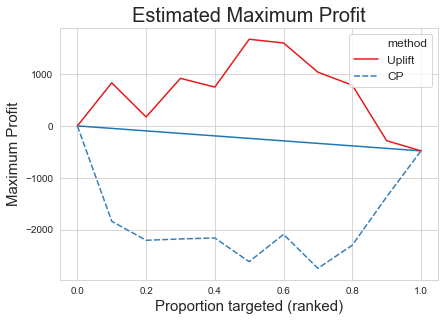

In [47]:
random = np.linspace(EMPC['emp'][0],EMPC['emp'][k],k+1)
sns.lineplot(x=EMPC.n, y=random)
sns.lineplot(x='n', y='emp', hue='method', data=result_emp, style="method", palette='Set1')
sns.set_style("whitegrid")
plt.title('Estimated Maximum Profit',fontsize=20)
plt.xlabel('Proportion targeted (ranked)',fontsize=15)
plt.ylabel('Maximum Profit',fontsize=15)
plt.subplots_adjust(right=1)
plt.subplots_adjust(top=1)
plt.legend(fontsize=12)

<h2>Treatment and Control

In [67]:
#prepare 3 dataframe for CPMPU
CPMPU = pd.DataFrame({"n":[], 
                      "QINI":[], 
                      "TR":[],  
                      "mpu":[]})
CUMPU, PUMPU = CPMPU.copy(), CPMPU.copy()
CP_list, CU_list, PU_list = [], [], []

#prepare dataframe for QINI Curves
QU = pd.DataFrame({"n":[],  
                    "uplift":[]})
QC = QU.copy()
QP = QU.copy()
QU_list, QC_list, QP_list = [], [], []
p4_1=(b1-i1)

j = 10
k = math.ceil(len(df_data_churn_all)/j)
for i in range(j):
    m=(i+1)*k 
    
#     #Input total actual control and treatment data
    churn_control_count = sum(df_data_churn_all[treat]==0)
    churn_treatment_count = sum(df_data_churn_all[treat]==1)
#     #Input total actual control and treatment data
    uplift_control_count = sum(df_data_uplift_all[treat]==0)
    uplift_treatment_count = sum(df_data_uplift_all[treat]==1)
    #Actual Qini Churn - Input Data
    RC_churn = sum((df_data_churn_all.Stay[0:m]==1)&(df_data_churn_all[treat][0:m]==0))
    RT_churn = sum((df_data_churn_all.Stay[0:m]==1)&(df_data_churn_all[treat][0:m]==1))
    NC_churn = sum(df_data_churn_all[treat][0:m]==0)
    NT_churn = sum(df_data_churn_all[treat][0:m]==1)
    #Actual Qini Uplift - Input Data
    RC_uplift = sum((df_data_uplift_all.Stay[0:m]==1)&(df_data_uplift_all[treat][0:m]==0))
    RT_uplift = sum((df_data_uplift_all.Stay[0:m]==1)&(df_data_uplift_all[treat][0:m]==1))
    NC_uplift = sum(df_data_uplift_all[treat][0:m]==0)
    NT_uplift = sum(df_data_uplift_all[treat][0:m]==1)
    #Predicted Qini Uplift - Input Data
    RC_predicted = sum(df_data_uplift_all.p_target[0:m]==1)
    RT_predicted = sum(df_data_uplift_all.p_target[0:m]==3)
    NC_predicted = sum(df_data_uplift_all.p_target[0:m]<=1)
    NT_predicted = sum(df_data_uplift_all.p_target[0:m]>=2)
    
#     pilih salah satu metode:    
    QINI_c = ((RT_churn/churn_treatment_count) - (RC_churn/churn_control_count))
    QINI_u = ((RT_uplift/uplift_treatment_count) - (RC_uplift/uplift_control_count))   
    #Calculate QINI
#     QINI_c = (RT_churn-((RC_churn*NT_churn)/NC_churn))
#     QINI_u = (RT_uplift-((RC_uplift*NT_uplift)/NC_uplift))
    QINI_p = (RT_predicted-((RC_predicted*NT_predicted)/NC_predicted))
    #Append to list
    QC_list.append(pd.Series([((i+1)/10), QINI_c], index=QC.columns))
    QU_list.append(pd.Series([((i+1)/10), QINI_u], index=QU.columns))
    QP_list.append(pd.Series([((i+1)/10), QINI_p], index=QU.columns))
    
    #Calculate MPU 
    #TR
    TR_churn=sum(df_data_churn_all.target_class[0:m] == 3)
    TR_uplift=sum(df_data_uplift_all.target_class[0:m] == 3) 
    #Qini & TR for churn prediction
    CP_profit = ((QINI_c*p4_1) - TR_churn)/m
    #Qini & TR for uplift prediction
    CU_profit = ((QINI_u*p4_1) - TR_uplift)/m
    #Qini & TR for uplift prediction
    PU_profit = ((QINI_p*p4_1) - RT_predicted)/m
    #Append to list
    CP_list.append(pd.Series([((i+1)/10), QINI_c, TR_churn, CP_profit], index=CPMPU.columns))  
    CU_list.append(pd.Series([((i+1)/10), QINI_u, TR_uplift, CU_profit], index=CUMPU.columns))
    PU_list.append(pd.Series([((i+1)/10), QINI_p, RT_predicted, PU_profit], index=CUMPU.columns))
    
    
# append list into dataframe    
QU = QU.append(QU_list , ignore_index=True)
QC = QC.append(QC_list , ignore_index=True)
QP = QP.append(QP_list , ignore_index=True)
# add q0 into dataframe for Qini Curve
q0 = pd.DataFrame({'n':0, 'uplift':0}, index =[0])
QU = pd.concat([q0, QU]).reset_index(drop = True)
QC = pd.concat([q0, QC]).reset_index(drop = True)
QP = pd.concat([q0, QP]).reset_index(drop = True)

# append MPU list into dataframe    
CPMPU = CPMPU.append(CP_list , ignore_index=True)
CUMPU = CUMPU.append(CU_list , ignore_index=True)
PUMPU = PUMPU.append(PU_list , ignore_index=True)
# add q0 into MPU dataframe
q0 = pd.DataFrame({'n':0, 'mpu':0}, index =[0])
CPMPU = pd.concat([q0, CPMPU]).reset_index(drop = True)
CUMPU = pd.concat([q0, CUMPU]).reset_index(drop = True)
PUMPU = pd.concat([q0, PUMPU]).reset_index(drop = True)

In [68]:
CPMPU['Churn Prediction MPU'] = CPMPU['mpu']
CPMPU['Uplift Prediction MPU'] = CUMPU['mpu']
CPMPU['Predicted Uplift MPU'] = PUMPU['mpu'] 
CPMPU = CPMPU.drop(['mpu', 'QINI', 'TR'], axis=1)
CPMPU

,n,Churn Prediction MPU,Uplift Prediction MPU,Predicted Uplift MPU
0,0.0,0.000000,0.000000,0.000000
1,0.1,-25.259148,48.510432,37022.033333
2,0.2,-9.451381,20.073091,35933.150000
3,0.3,-0.669288,39.393695,33057.353846
4,0.4,-2.070263,27.454209,29680.756452
5,0.5,-5.854975,25.777199,25097.146847
6,0.6,-5.213790,12.015752,23548.057995
7,0.7,-11.076530,5.794597,18666.361905
8,0.8,-1.516297,10.872693,11278.893711
9,0.9,3.345207,0.073955,7284.822487


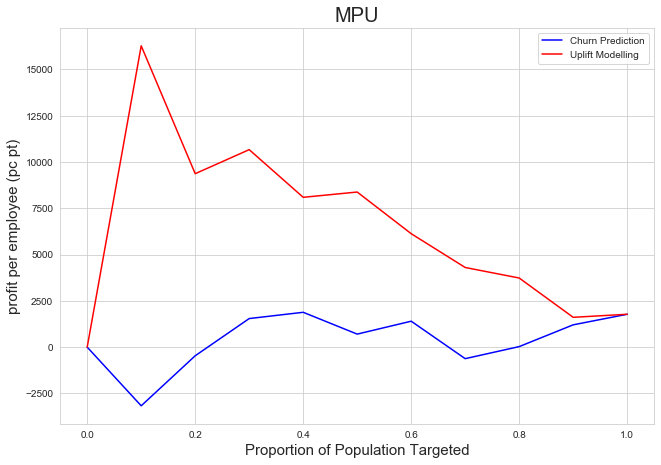

In [50]:
sns.lineplot(x=CPMPU.n, y=CPMPU['Churn Prediction MPU'], label='Churn Prediction', color='blue')
sns.lineplot(x=CPMPU.n, y=CPMPU['Uplift Prediction MPU'], label='Uplift Modelling', color='red')
# sns.lineplot(x=CPMPU.n, y=CPMPU['Predicted Uplift MPU'], label='Predicted Uplift Modelling', color='green')

sns.set_style("whitegrid")
plt.title('MPU',fontsize=20)
plt.ylabel('profit per employee (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

In [51]:
QP = QP.rename(columns={"uplift": "Predicted Uplift QINI"})
QP['Actual Uplift QINI'] = QU['uplift']
QP['Actual Churn QINI'] = QC['uplift']
QP

,n,Predicted Uplift QINI,Actual Uplift QINI,Actual Churn QINI
0,0.0,0.000000,0.000000,0.000000
1,0.1,17.000000,7.470588,-1.454545
2,0.2,33.000000,8.600000,-0.428571
3,0.3,45.538462,14.687500,2.125000
4,0.4,54.516129,14.857143,3.454545
5,0.5,57.621622,19.226415,1.615385
6,0.6,64.878049,16.875000,3.857143
7,0.7,60.000000,13.821918,-2.000000
8,0.8,41.433962,13.708861,0.105263
9,0.9,30.107143,6.651685,4.976744


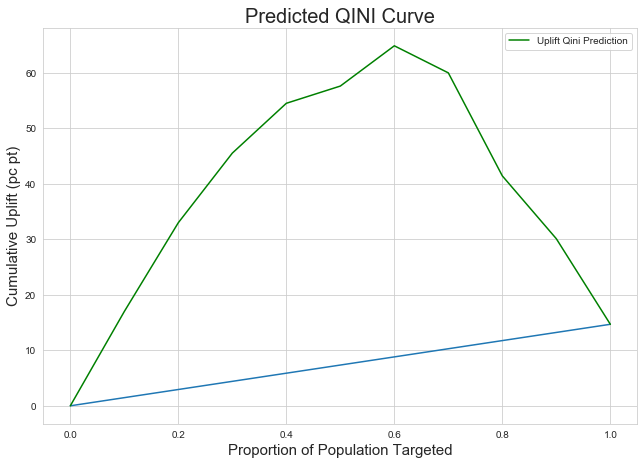

In [52]:
random = np.linspace(QP['Predicted Uplift QINI'][0],QP['Predicted Uplift QINI'][j],j+1)
sns.lineplot(x=QP.n, y=random)
sns.lineplot(x=QP.n, y=QP['Predicted Uplift QINI'], label="Uplift Qini Prediction", color="green")
sns.set_style("whitegrid")
plt.title('Predicted QINI Curve',fontsize=20)
plt.ylabel('Cumulative Uplift (pc pt)',fontsize=15)
plt.xlabel('Proportion of Population Targeted',fontsize=15)
plt.subplots_adjust(right=1.5)
plt.subplots_adjust(top=1.5)

In [69]:
#create new column method = churn_prediction
QC['method'] = 'CP'

#create new column method = uplift_modelling Prediction
QU['method'] = 'Uplift'

#Combine both Churn Prediction and uplift modelling result
result_QINI = pd.concat([QC, QU])
result_QINI = result_QINI.sort_values(by='n')
result_QINI

,n,uplift,method
0,0.0,0.000000,CP
0,0.0,0.000000,Uplift
1,0.1,-0.011568,CP
1,0.1,0.022413,Uplift
2,0.2,-0.008573,CP
2,0.2,0.018694,Uplift
3,0.3,-0.000723,CP
3,0.3,0.054741,Uplift
4,0.4,-0.003512,CP
4,0.4,0.051023,Uplift


In [70]:
#store dataset to be used globally
result_QINI_3 = result_QINI
%store result_QINI_3

Stored 'result_QINI_3' (DataFrame)


<h2>Pylift

In [ ]:
df_data_pylift = df_model.copy()
df_data_pylift.drop(['target_class'], axis=1)
df_data_pylift

pylift modelling

In [ ]:
up = TransformedOutcome(df_model, col_treatment=treat, col_outcome='Stay')

In [ ]:
up.randomized_search(n_iter=20, n_jobs=10, random_state=46)

In [ ]:
up.fit(**up.rand_search_.best_params_)

In [ ]:
up.plot(plot_type='cuplift')

In [ ]:
up.test_results_.q1_cgains

In [ ]:
up.plot(plot_type='qini')

In [ ]:
up.shuffle_fit(params=up.rand_search_.best_params_, nthread=30, iterations=5);
up.plot(show_shuffle_fits=True)

In [ ]:
up.plot(show_theoretical_max=True, show_practical_max=True, show_no_dogs=True)

<h1>Causal Lift

In [ ]:
def calc_cumulative_gains(df: pd.DataFrame, actual_col: str, predicted_col:str, probability_col:str):
    df.sort_values(by=probability_col, ascending=False, inplace=True)

    subset = df[df[predicted_col] == True]

    rows = []
    for group in np.array_split(subset, 10):
        score = sklearn.metrics.accuracy_score(group[actual_col].tolist(),
                                                   group[predicted_col].tolist(),
                                                   normalize=False)

        rows.append({'NumCases': len(group), 'NumCorrectPredictions': score})

    lift = pd.DataFrame(rows)

    #Cumulative Gains Calculation
    lift['RunningCorrect'] = lift['NumCorrectPredictions'].cumsum()
    lift['PercentCorrect'] = lift.apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x['RunningCorrect'], axis=1)
    lift['CumulativeCorrectBestCase'] = lift['NumCases'].cumsum()
    lift['PercentCorrectBestCase'] = lift['CumulativeCorrectBestCase'].apply(
        lambda x: 100 if (100 / lift['NumCorrectPredictions'].sum()) * x > 100 else (100 / lift[
            'NumCorrectPredictions'].sum()) * x)
    lift['AvgCase'] = lift['NumCorrectPredictions'].sum() / len(lift)
    lift['CumulativeAvgCase'] = lift['AvgCase'].cumsum()
    lift['PercentAvgCase'] = lift['CumulativeAvgCase'].apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x)

    #Lift Chart
    lift['NormalisedPercentAvg'] = 1
    lift['NormalisedPercentWithModel'] = lift['PercentCorrect'] / lift['PercentAvgCase']

    return lift

In [ ]:
cum_lift = calc_cumulative_gains(df_data_churn, 'Stay', 'p_stay', 'stay_score')
cum_lift

In [ ]:
sns.lineplot(x='PercentAvgCase',y='PercentCorrectBestCase',data=cum_lift, label="Best Case (for current model)")
sns.lineplot(x='PercentAvgCase',y='PercentAvgCase',data=cum_lift, label="Average Case (for current model)")

In [ ]:
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentWithModel',data=cum_lift, label="Normalised Respond Rate With Model")
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentAvg',data=cum_lift, label="Normalised Respond Rate Avg")

In [ ]:
cum_uplift = calc_cumulative_gains(df_data_uplift, 'target_class', 'p_target', 'uplift_score')
cum_uplift

In [ ]:
sns.lineplot(x='PercentAvgCase',y='PercentCorrectBestCase',data=cum_uplift, label="Best Case (for current model)")
sns.lineplot(x='PercentAvgCase',y='PercentAvgCase',data=cum_uplift, label="Average Case (for current model)")

In [ ]:
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentWithModel',data=cum_uplift, label="Normalised Respond Rate With Model")
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentAvg',data=cum_uplift, label="Normalised Respond Rate Avg")

In [ ]:
#create feature set and labels
df_model_causal = df_model.drop(['target_class','p_stay','p_target'],axis=1)
df_model_causal.rename(columns={treat:'Treatment','Stay':'Outcome'}, inplace=True)
df_model_causal

In [ ]:
#splitting train and test groups
train_df, test_df = train_test_split(df_model_causal, test_size=0.2, random_state=42, stratify=df_model_causal['Treatment'])

In [ ]:
""" Step 0. Import CausalLift
"""

from causallift import CausalLift

""" Step 1. Feed datasets and optionally compute estimated propensity scores
using logistic regression if set enable_ipw = True.
"""


cl = CausalLift(train_df, test_df, enable_ipw=True, verbose=3)

""" Step 2. Train 2 classification models (XGBoost) for treated and untreated
samples independently and compute estimated CATE (Conditional Average Treatment
Effect), ITE (Individual Treatment Effect), or uplift score.
"""

train_df, test_df = cl.estimate_cate_by_2_models()

""" Step 3. Estimate how much conversion rate will increase by selecting treatment
(campaign) targets as recommended by the uplift modeling.
"""

estimated_effect_df = cl.estimate_recommendation_impact()

In [ ]:
estimated_effect_df